# Sprawozdanie z Klasyfikacji Tesktur (Ćwiczenie nr 3)

Autor: Mateusz Kamiński

Celem ćwiczenia jest zapoznanie się z algorytmami ekstrakcji cech na potrzeby klasyfikacji wektorów danych.

# Przebieg ćwiczenia

1. W pierwszej kolejności należało wykonać zdjęcia 3 jednorodnych powierzchni o charakterystycznej teksturze, a następnie zapisać zdjęcia reprezentujące różne tekstury do odrębnych katalogów. W tym przypadku wykonano po 3 zdjęcia 3 tekstur: beton, drewno oraz dzianina. Przykładowe zdjęcia zaprezentowano poniżej.

<table><tr>
<td> 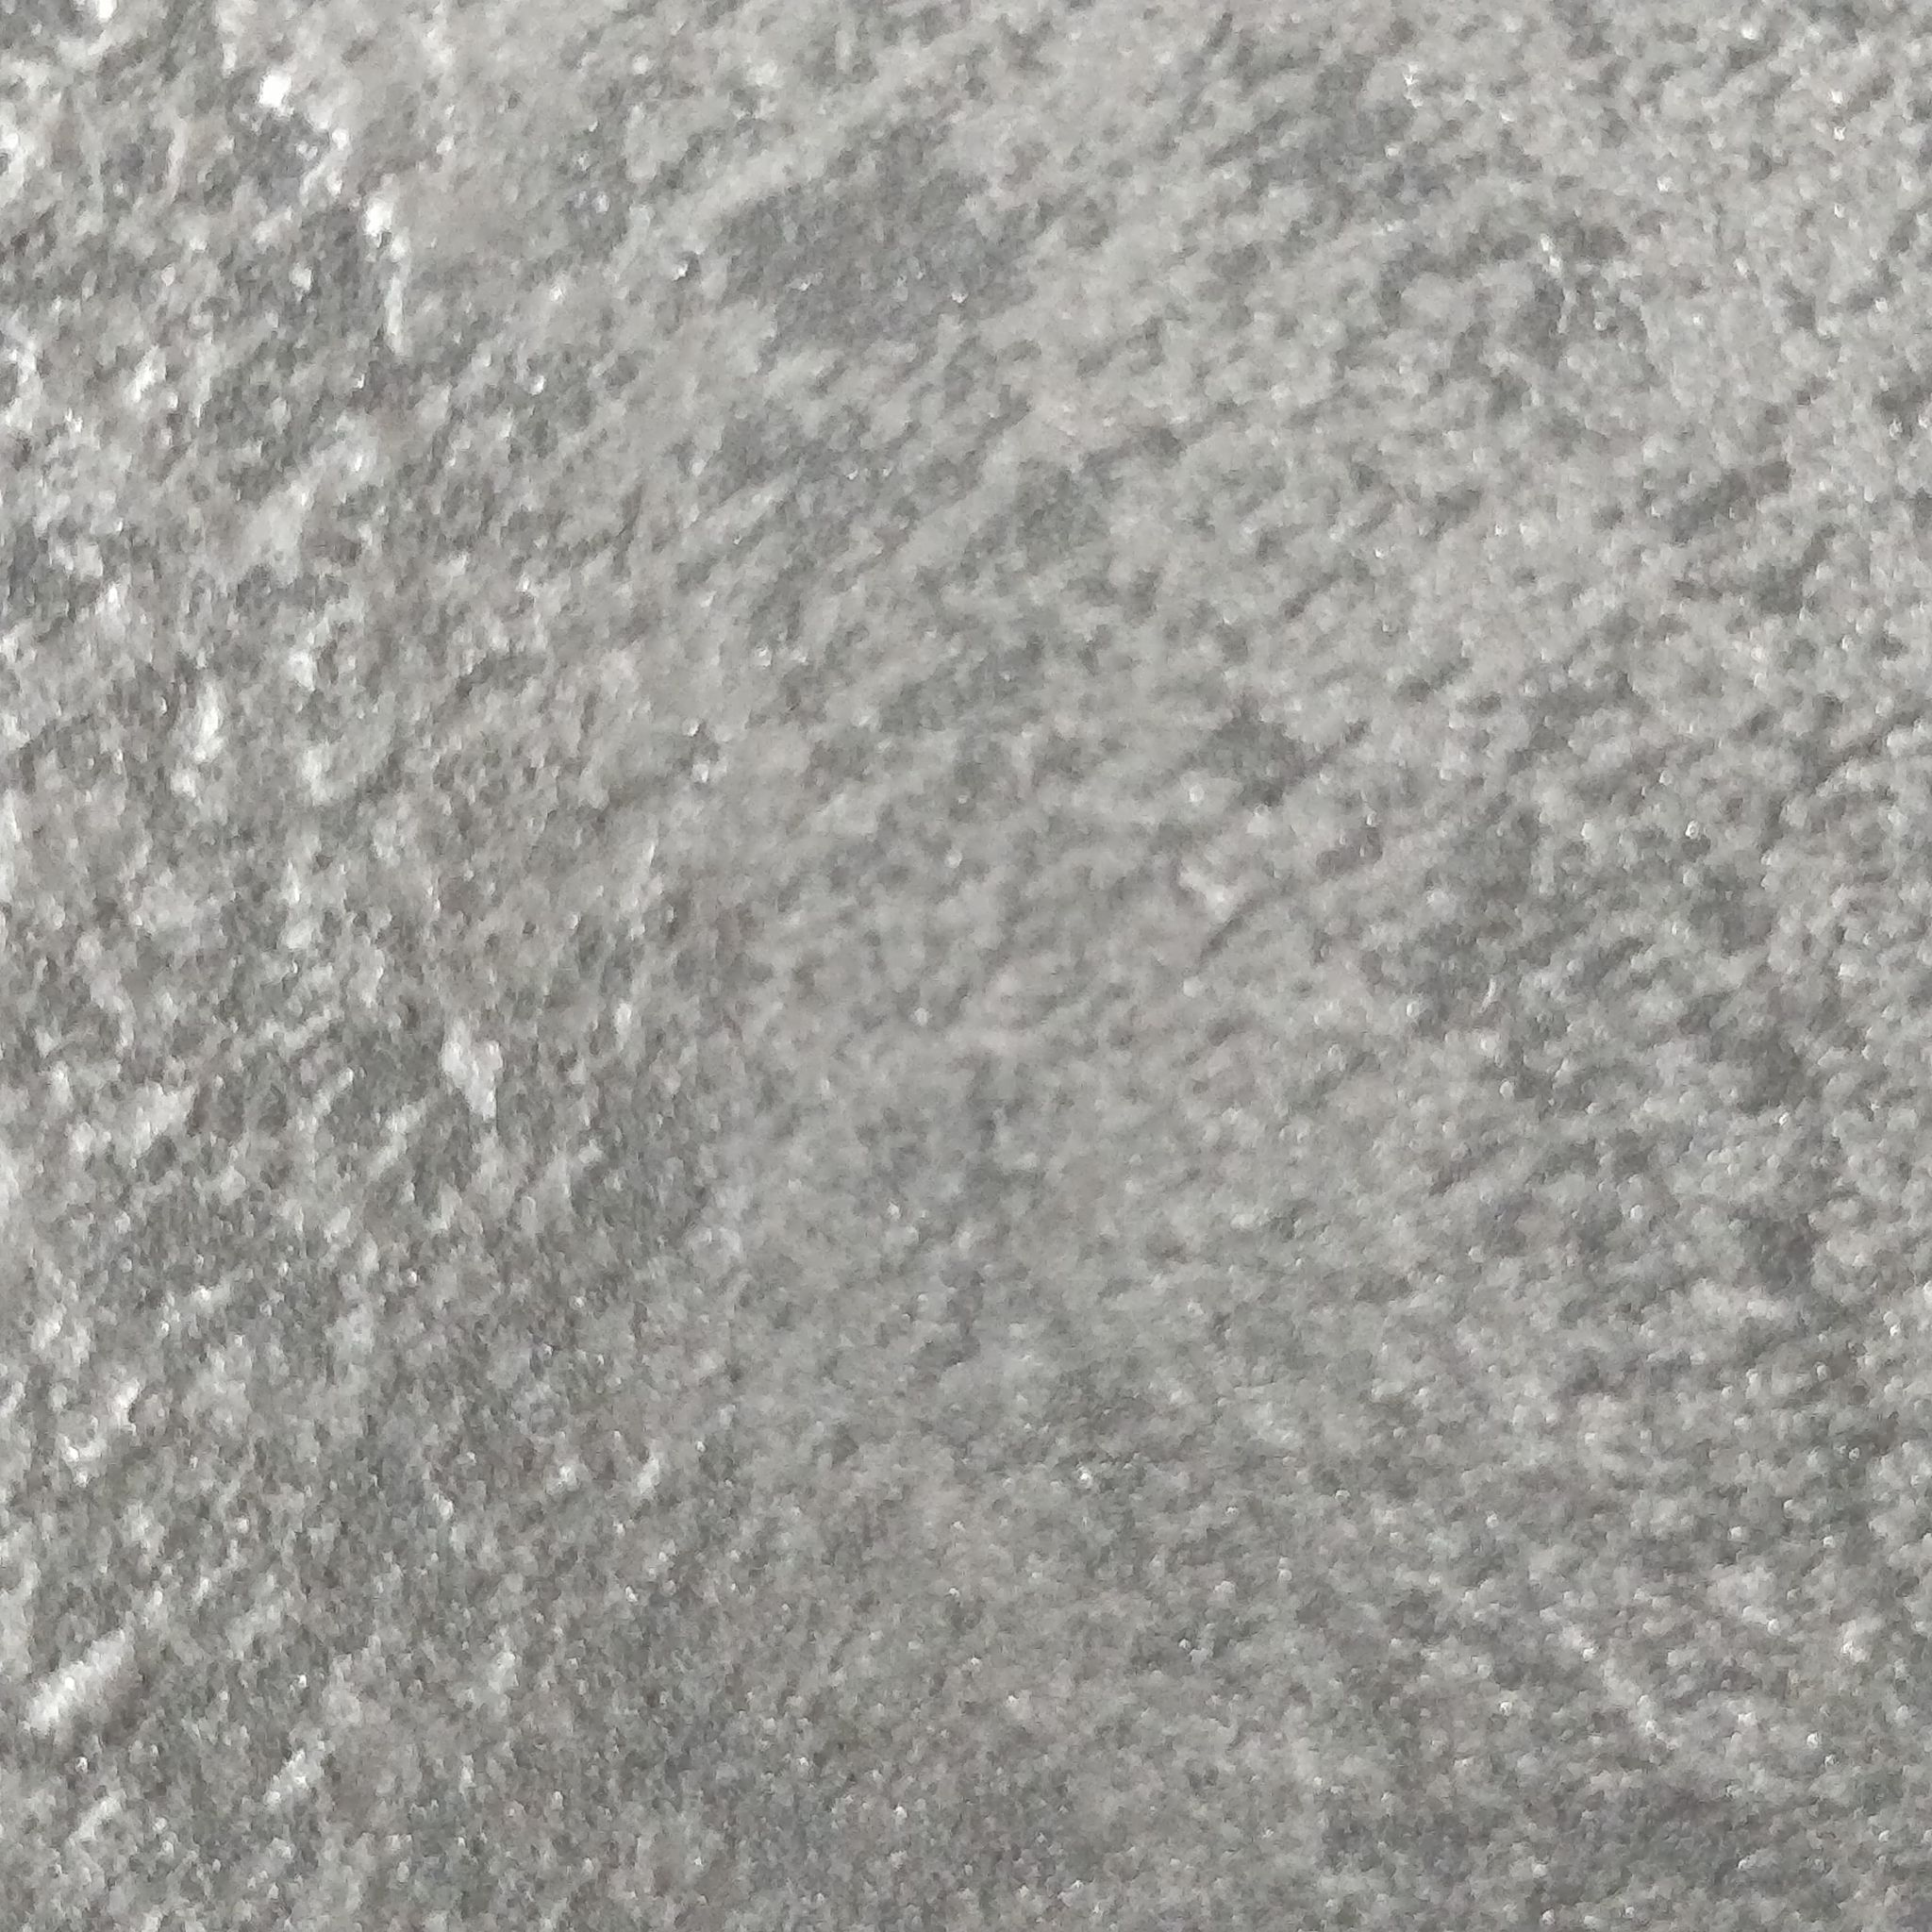  </td>
<td> 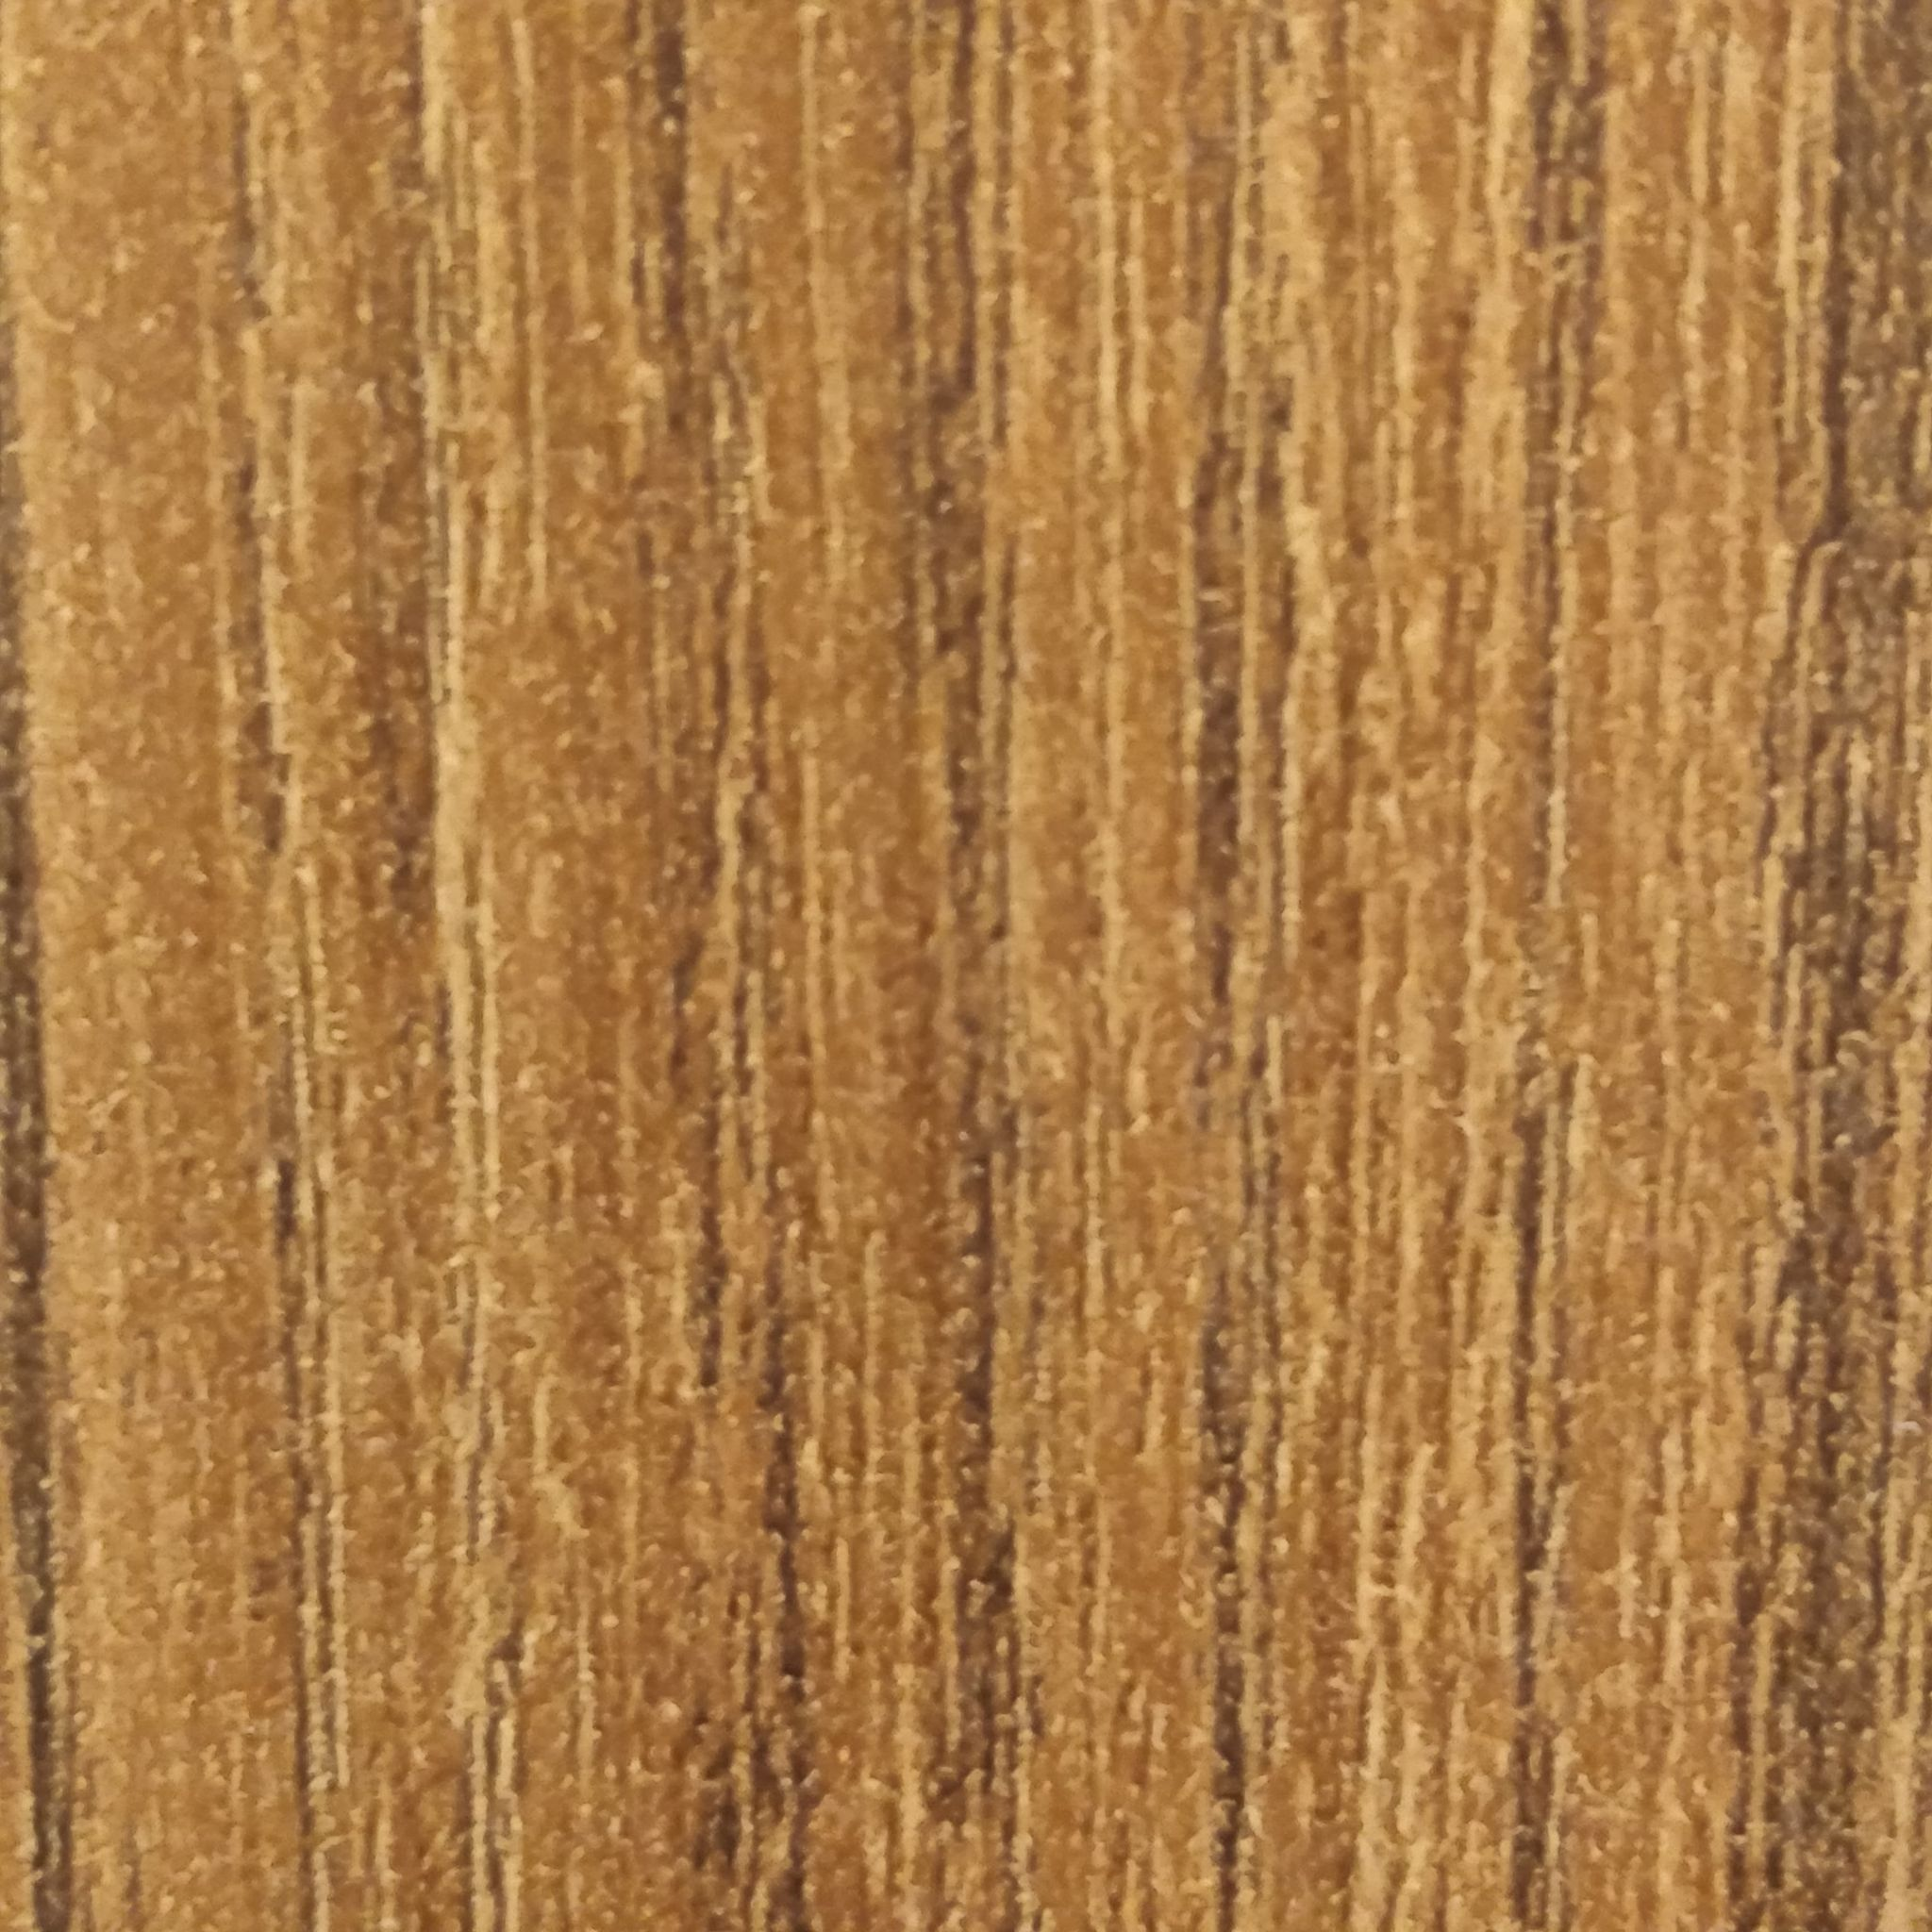  </td>
<td> 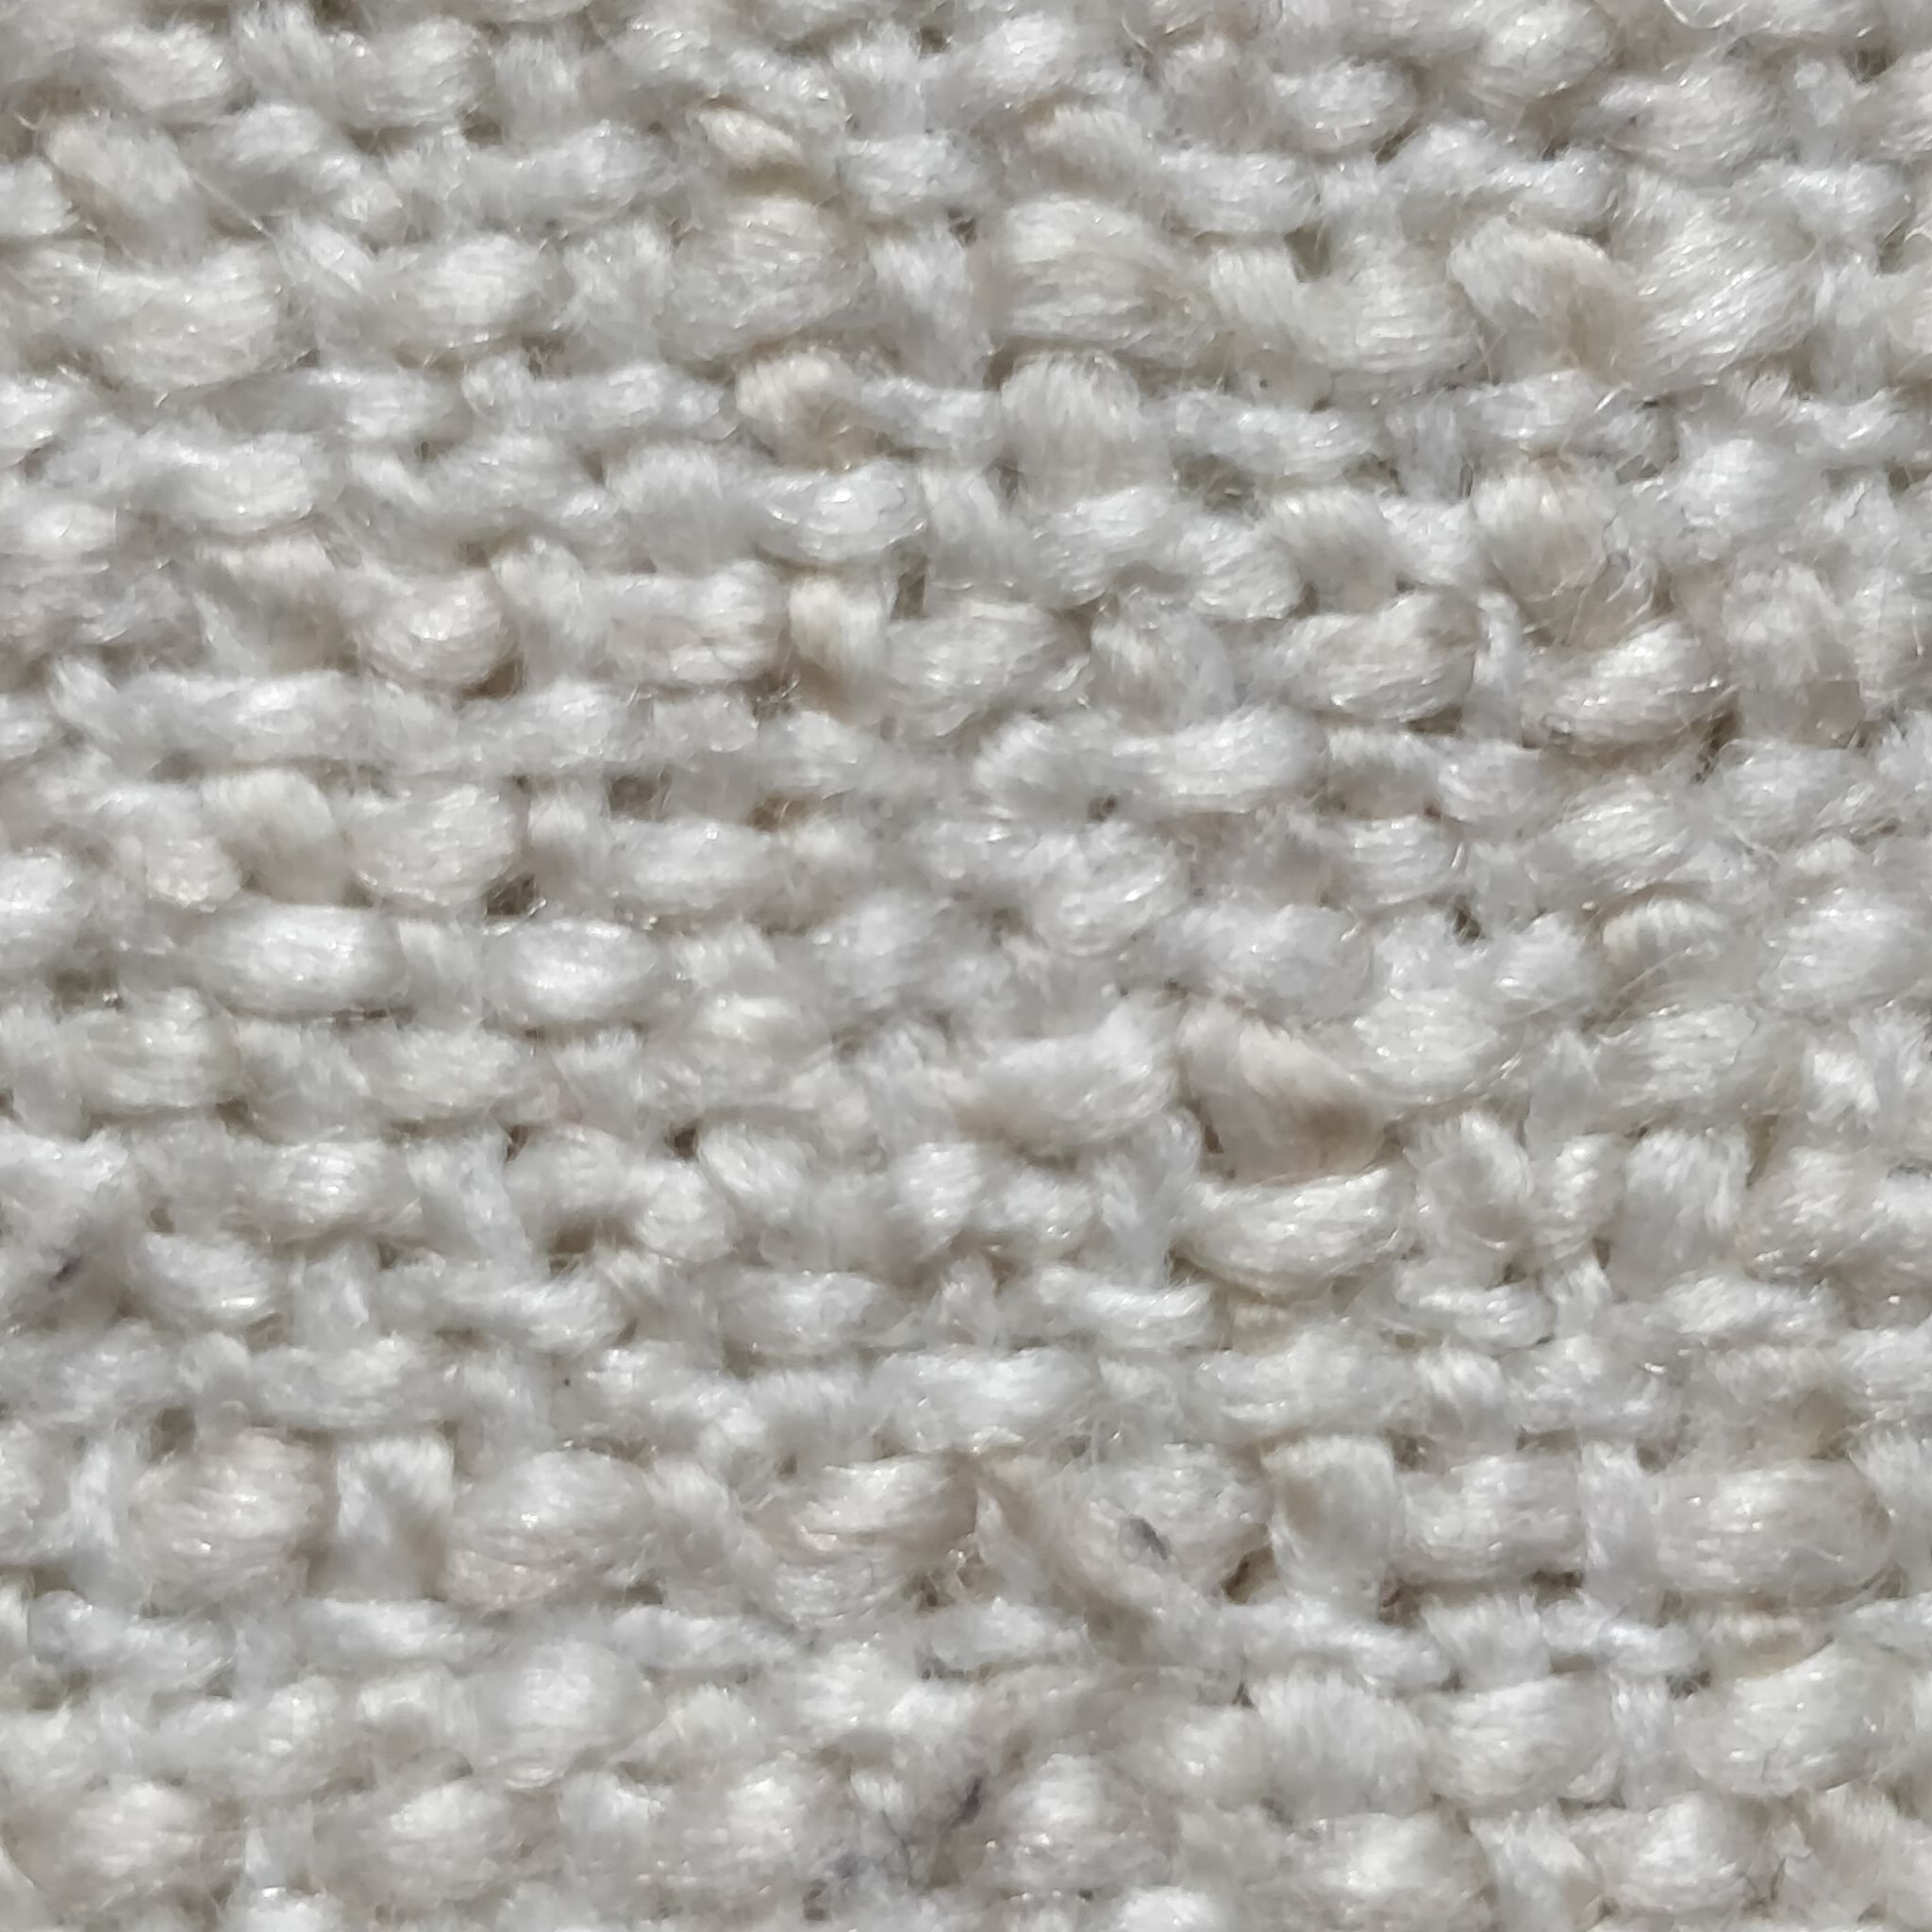  </td>
</tr></table>

2. Nastęonym krokiem było podzielenia każdego ze zdjęć na małe próbki (128x128 pikseli) oraz przekonwertowanie ich na skalę szarości. Funkcja konwertująca dowolne zdjęcie klasy została zaprezentowana poniżej.

In [17]:
def conv_to_gray_sample(area, size_x, size_y): #area = klasa powierzchni, size_x, size_y = wymiary próbki
    pictures = os.listdir(area)
    num_samples = 10  # num_samples = samples form 1 picture
    g = 0
    for i in range(0, len(pictures)):
        img = io.imread('Sprawozdanie_Ex3/' + area + '/' + pictures[i], as_gray=True)
        x = 0
        y = 0
        for p in range(0, num_samples):
            cropped_img = img[x:size_x + x, y:size_y + y]
            img_sample_conv = (cropped_img / np.max(cropped_img) * 63).astype('uint8')
            x = x + size_x
            y = y + size_y
            io.imsave('Sprawozdanie_Ex3/' + "conv_" + area + "/" + area + "_grey_" + str(g + 1) + ".jpg", img_sample_conv)
            g=g+1

W wyniku tej funkcji powstaje 10 próbek na jedno zdjęcie, przykładowe próbki dla betonu, drewna i dzianiny zostały zaprezentowane poniżej.

<table><tr>
<td> 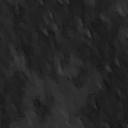 </td>
<td> 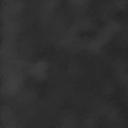 </td>
<td> 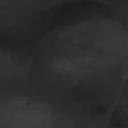 </td>
</tr></table>

3. Kolejnym krokiem jest stworzenie funkcji wczytywania próbek tekstury i wyznaczania dla nich cech tekstury na podstawie modelu macierzy zdarzeń za pomocą odpowiednich funkcji z pakietu scikit-image. Funkcja została zaprezentowana poniżej.

In [22]:
def create_vector(area):
    pictures = os.listdir(area)
    num_samples = 10
    vectors = []
    for i in range(0, len(pictures) * num_samples):
        img = io.imread("conv_" + area + "/" + area + "_grey_" + str(i + 1) + ".jpg", as_gray=True)
        #img_conv = (img / np.max(img) * 63).astype('uint8')
        img_conv = img_as_ubyte(img)
        feat_greyco = skimage.feature.graycomatrix(img_conv, [1], [45], levels=256, normed=True)

        contrast = round(skimage.feature.graycoprops(feat_greyco, 'contrast')[0][0], 5)
        energy = round(skimage.feature.graycoprops(feat_greyco, 'energy')[0][0], 5)
        homogeneity = round(skimage.feature.graycoprops(feat_greyco, 'homogeneity')[0][0], 5)
        correlation = round(skimage.feature.graycoprops(feat_greyco, 'correlation')[0][0], 5)
        dissimilarity = round(skimage.feature.graycoprops(feat_greyco, 'dissimilarity')[0][0], 5)
        ASM = round(skimage.feature.graycoprops(feat_greyco, 'ASM')[0][0], 5)
        vector = [area, contrast, energy, homogeneity, correlation, dissimilarity, ASM]
        vectors.append(vector)
    with open("vector.csv", "a") as file:
        np.savetxt(file, np.array(vectors), fmt="%s", delimiter=',')

W wyniku tej funkcji powstaje plik z rozszerzeniem CSV z różnymi wartościami cech oraz nazwą klasy. Tabela z przykładowymi wartościami cech poszczególnych klas znajduje się poniżej

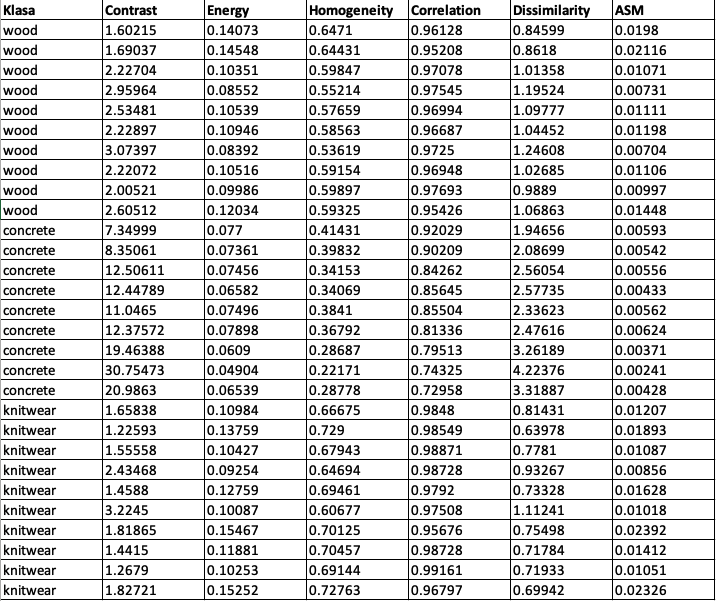

4. Ostatnim krokiem jest napisanie skryptu do klasyfikacji wektorów cech z wykorzystaniem dowolnego algorytmu klasyfikacji danych dostępnego w pakiecie scikit-learn, a następnie obliczyć i wyświetlić na ekranie wyznaczoną dokładność klasyfikatora.

In [23]:
def read_train_and_test():
    with open("vector.csv", 'r') as file:
        reader = csv.reader(file, delimiter=',')
        data2 = list(reader)
        data = np.array(data2)
        X = data[:, 1:]
        Y = data[:, 0]

        classifier = svm.SVC(gamma='auto')
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=6)
        classifier.fit(x_train, y_train)
        y_pred = classifier.predict(x_test)
        accuracy = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred, normalize='true')
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Wood', 'Concrete', 'Knitwear'], cmap=plt.cm.Reds)
        plt.show()
        return accuracy

W wyniku funkcji otrzymano następujący wykres:

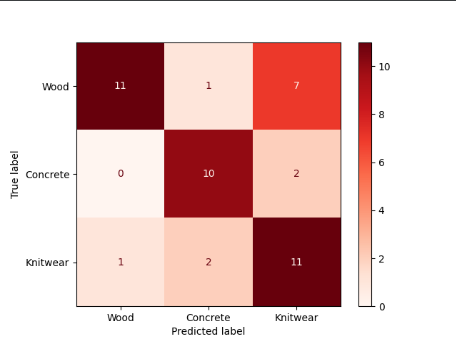

# Wnioski

Na podstawie powyższego wykresu można zaobserwować że algorytm nie działa idealnie, ponieważ część przewidzianych klas nie trafiła w miejsce prawdziwej klasy. Najgorzej wygląda to w dla drewna, przy którym aż 7 sampli trafiło w miejsce dzianiny. Może to być spowodowane zbyt podobnymi próbkami obu klas co jest widoczne na przykładowych zdjęciach powyżej. Dokładność klasyfikatora wyniosła 0.71, co oznacza, że nie wszystkie obiekty zostały poprawnie sklasyfikowane. Do eksperymentu użyto 50% wygenerowanych próbek.